# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of transmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

# Introduction to Delay Tolerant Networks

Delay Tolerant Networking (DTN) is a relatively new area of research which 
is rapidly becoming the focus of considerable effort. DTN is an approach
to computer architecture that seeks to address the technical issues in 
heterogeneus networks that may lack continuos network connectivity. The
final aim of this developing study area is to tackle problems which the 
Internet is not able to face.  

There's a great variety among the different DTNs: they range from deep 
space networks to buses driving around mobile wireless hotspots in 
villages to provide Internet service to kiosks. 

The big difference from the regular Internet Protocol (IP) is that IP
assumes a seamless end-to-end data path instead DTNs are built to account
for errors and disconnections. Unlike IP, where heterogeneus networks are 
connected by assigning each node a common network-layer identifier (IP address),
a DTN uses "naming, layering, encapsulation and persistent storage".

The situations in which we use DTNs are pretty challenging:

* The throughput is generally low (we can think for instance about the acoustic in underwater modems) and may 
be highly asymmetric or in the worse scenario a return channel might not 
exist

* These networks are frequently disconnected, not only by faults but due
to motion for instance

* These systems frequently operate with a low duty cycle and the queuing 
time can be very large; with these conditions TCP would time out the session
instead UDP would lose all the packets.

In [1]:
#used to import the utility functions
import sys
sys.path.insert(1, "utility_functions/")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math
import pylab as pl
from matplotlib import collections  as mc
import mpl_toolkits.mplot3d.axes3d as p3
from network_utilities import generate_network, plot_network, disable_links, adjacency_matrix
from greedy_routing import greedy_routing, DTN_dijkstra
from graphics import pkt_plot
from metrics import throughput, delay, deviations
import pandas as pd
from epidemics import add_packet, arrive_to_earth, check_link
################################################
n = 10                                         #
c = 3e8                                        #
T_tx = 10  # da regolare                       #
r_max = 60e9  # Marte                          #
tau_max = 200                                  #
################################################

In [2]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth

if(False):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

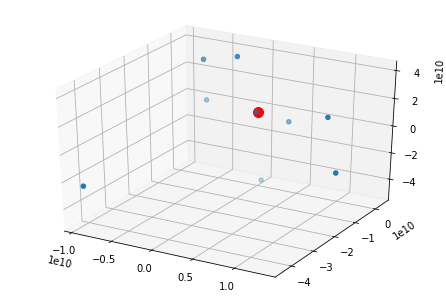

In [3]:
plot_network(nodes)

In [4]:
### TEST disable links
### sorted nodes = [0 4 5 8 1 2 9 3 6 7]

if(False):   #TEST
    At = disable_links(A,100,1,mode="unstable")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()

# Greedy Routing

In every network where data is generated from a node and needs to be delivered to a different one, may it be the postal network or the internet, it is necessary to find out the route that the data should follow in order to reach its destination.

This is usually done by a routing algorithm, in the internet the most widely used ones are the Dijikstra and the Bellman-Ford algorithm, these two are used in order to find the shortest way from the source to the destination according to some metric that could be the number of hops, the end to end delay etc.
<!-- The code below is html and I used it because it gives much more freedom for
controlling images-->
<figure>
    <img src="figures/routing.svg" width=500/>
    <div style="text-align: center;"> 
        <i>
            Path obtained by applying routing between the two nodes
        </i>
    </div>
</figure>
Classical routing algorithms do not work on DTNs (Delay Tolerant Networks) because they were thought for systems where links are supposed to fail very rarely and where the end to end delay is relatively small.

In the internet the chance of a link failing is low and even if it does the end to end delay is small, so in case a packet is lost because of link failure sending the packet again is not too expensive.
In DTNs this is not true because:

* The propagation time is very high, expecially if we are conisdering satellite communication

* The chanche of link failure is very high.

On top of that it is not even possible to find the best routing algorithm for networks in general because if the traffic generated by other nodes is considered the problem becomes NP.
By analyzing the state of the art in DTN it is possible to see that the best results were mostly obtained by using greedy algorithms, i. e. algorithms that make a decision by choosing the best choice at the moment without considering long term planning.

In order to perform routing, during the first part of the project, full knowledge of the network topology and also its evolution is taken as a given, this is not a very strict requirement as this might happen in real life. For example for satellite networks, where usually link failure is caused by the interference of a celestial body, the requirement can be easily satisfied.

The algorithm implemented with this work chooses the best next hop for the packet by using a slightly modified version of the dijkstra algorithm that computes the best path from the source to the destination at a specific point in time.

It is also necessary to take collisions into account, so if sending one packet causes one the sender needs to wait until it is sure that no collision will occur, after waiting the optimal path needs to be recomputed because due to topology changes it might not be optimal anymore.

## Modified Dijkstra

The Dijkstra algorithm cam be used to find the best path between two nodes in a weighted graph with positive weights.

<figure>
    <img src="figures/dijkstra.gif" width=300/>
    <div style="text-align: center;"> 
        <i>
            Dijkstra algorithm in action
        </i>
    </div>
</figure>

Usually the algorithm is run on graphs that have constant topology but in this case the topology changes a lot so a link that was active when the packet was sent might not be active when the packet reaches its destination.

A nice implementation of the Dijkstra algorithm for DTNs was proposed in [1], in there the weigth of a node is considered equal to the time it would take the packet to reach the next hop considering that the link might fail.

The pseudo code for the algorithm is:
```
Input = G=(E, V), s, T, w(e,t)
Q = V
L[s]=0
L[v]=inf for every v != s
while Q != {} do
    u = u in Q that minimizes L[u]
    Q = Q - u
    for each edge e in E between u and another vertex v do
        if L[v] > L[u] + w(e, T + L[u]) then
            L[v] = L[u] + w(e, T + L[u])
        end if
    end for
end while
```
Where G is the graph representing the network, s is the starting node, T is the starting time, w(e,t) is the weight of edge e at time t.
The only difference from the standard algorithm is that in the standard case w(e,t) is constant in t.


In [5]:
At = disable_links(A,3000,1,mode="unstable")

In [6]:
packets = np.random.randint(1, n, (100, 2))
packets[:,1] = 0
packets = packets[packets[:, 0] != 0]
print(len(packets))
#print(packets)
delta_time = 50
ttr = 50
packets = greedy_routing(At, packets, ttr, delta_time)

100


In [7]:
for packet in packets:
    if len(packet.route) > 2:
        print(packet.route)

In [8]:
#TEST 
#Here we test our function with 3 packets
if(False):
    n_pkts = 3
    T_tx = 0.5
    A=np.zeros((3,3))
    A[0,1] = A[1,0] = 1
    A[1,2] = A[2,1] = 2
    A[0,2] = 3

    scheduling = [[2,4],[1,5.5],[]]
    routing = [[[0,2],[0,1,2]],[[1,2]],[]]

    delay = delay(A, scheduling, routing, n_pkts, T_tx)
    print(delay)

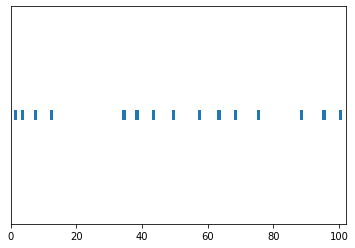

In [9]:
#Test of pkt_plot function
if(True):
    recept_times=[1,3,7,12,34,38,43,49,57,63,68,75,88,95,100]

    t_tx=1
    pkt_plot(recept_times,t_tx)

In [10]:
#TEST of deviations function
if(False):
    optimal = [[[0,0],[0,1],[0,2]],[[1,0],[1,1],[1,2]],[[2,0],[2,1],[2,2]]]  
    dev = deviations(optimal,routing,3)
    print(dev)

In [11]:
#TEST throughput using the delay function
if(False):
    throughput(n_pkts,delay)

# EPIDEMIC ALGORITHM

In [12]:
import numpy as np
import math
import pandas as pd

# n_packet = every list is the code of node with the same index, and 
#contains the ID packet that we want to send
# n_node_tot = number of nodes, in our case is 10 including the earth
# packet_trace = keep the trace of the road followed by each package
# trasmision_time = time to trasmit a single packet
# packet_arrive = [ID number of packets arrive to earth]
# packet_arrive_dupl = [ID number of all packets arrive to earth]
# vulnerable_time = [[start_time, finshed_time] collect the vunlerable 
#time for each node]
# slot_time = duration of each interval time
# packet_time = each list rappresent a single packet: the value is the
#time it takes to get to the earth, the index indicates
#               from which node the packet is send to earth.
#propagation_time = matrix that collects the propagation time between
#nodes when the connection is up

#B = disable_links(A,100,mode="light")
n_node_tot = At.shape[0]
n_packet_tot = 13
n_packet = [[],[0,1],[2,3,4],[5,6,7,8],[9],[],[],[10],[11],[12]]
packet_trace = [[],[0,1],[2,3,4],[5,6,7,8],[9],[],[],[10],[11],[12]]
transmission_time = 0.5
packet_arrive = []
vulnerable_time = np.zeros(n_node_tot)
slot_time = 10
packet_time = np.zeros((n_packet_tot, n_node_tot-1))
propagation_time = A
times = {
    "ttx": transmission_time,
    "vulnerable": vulnerable_time,
    "slot": slot_time,
    "packet": packet_time
}
print(At.shape)

#start time
for t in np.arange(0,At.shape[2]*slot_time,0.5):
    for i in range(1, n_node_tot):
        #print('tempo che scorre',t)
        if (np.array(n_packet[i])).size != 0:
            if t != 0:
                for p in n_packet[i]:
                    if packet_time[p, i-1] <= t:
                        packet_time[p, i-1] = packet_time[p, i-1] + 0.5
            
            # if the link to erath is down 
            if not check_link(At, i, 0, t, times):
                if ( (t >= vulnerable_time[i] + transmission_time) == True):
                    
                    times["vulnerable"], n_packet, packet_trace, times["packet"] = add_packet(
                        At,
                        t,
                        i, 
                        times,
                        n_packet,
                        packet_trace
                    )
                    
            else:
                
                if t >= vulnerable_time[i] + transmission_time:
                    
                    #this is all just one line
                    times["vulnerable"], n_packet, packet_trace, packet_arrive, times["packet"] = arrive_to_earth(
                        At,
                        t,
                        i,
                        times,
                        n_packet,
                        packet_trace,
                        packet_arrive
                    )
                    
    if len(n_packet) == 0:
        break


#the set is a data structure that removes all duplicates
print('packet_arrive', set(packet_arrive))
print('packet_arrive_dupl', packet_arrive)
data = pd.DataFrame(packet_time)
data       

(10, 10, 3000)
packet_arrive {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
packet_arrive_dupl [0, 2, 4, 5, 7, 9, 10, 11, 1, 3, 6, 8, 12, 12, 12, 12, 12, 12, 12]


,0,1,2,3,4,5,6,7,8
0,56.673877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,57.173877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,85.903518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,86.903518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,86.403518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,169.955226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,170.955226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,170.455226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,171.455226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,1.943771,0.000000,0.000000,0.000000,0.000000,0.000000


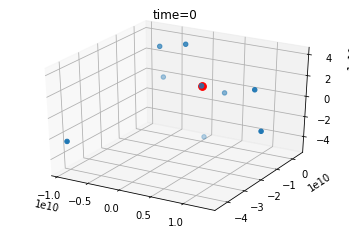

In [13]:
## ANIMATION 1

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

#%matplotlib notebook 

coord = np.copy(nodes)
polar = generate_network(n,r_max,polar=True)

def update_graph(num):

    theta = polar[:,1]
    phi = polar[:,2]
    
    old_r = np.linalg.norm(coord,axis=1)
    
    coord[:,0] += - c*np.cos(theta)*np.sin(phi)
    coord[:,1] += - c*np.sin(theta)*np.sin(phi)
    coord[:,2] += - c*np.cos(phi)
    
    new_r = np.linalg.norm(coord,axis=1)
    
    not_done = new_r < old_r  #this happens after a packet reach Earth

    #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

    for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
        if not not_done[i]:
            coord[i,0] = coord[i,1] = coord[i,2] = 0
            
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani = animation.FuncAnimation(fig, update_graph, 
                               interval=50, blit=False)

plt.show()

<IPython.core.display.Javascript object>


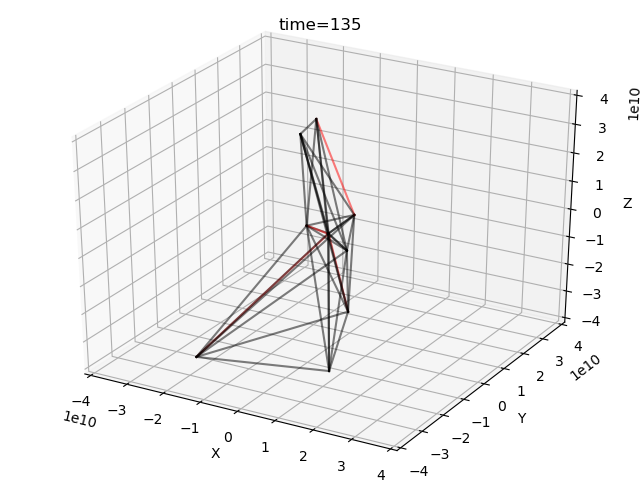

In [14]:
## ANIMATION 2

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

#%matplotlib notebook 

#returns a list of active links
def get_links(A):
    n = A.shape[0]
    return [np.array([nodes[i],nodes[j]]).T for i in range(n) for j in range(i+1) if A[i,j]!=np.inf]

#checks if a link is active 
def check_link(link, link_list):
    for x in link_list:
        if np.array_equal(x, link):
            return True
    return False

#At = disable_links(A,5000,1,mode="heavy")  #test

n_updates = At.shape[2]
links = get_links(A)
active_links = [get_links(At[:,:,t]) for t in range(n_updates)]

def update_lines(num, dataLines, lines) :

    title.set_text("time={}".format(num))
    
    for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :])
        line.set_3d_properties(data[2, :])
        line.set_color("black")
        if not check_link(data, active_links[num]):
              line.set_color("red")
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

data = links
lines = [ax.plot(dat[0, :], dat[1, :], dat[2, :],alpha=0.5)[0] for dat in links]

if True:   #autoscale off
    # Setting the axes properties
    ax.set_xlim3d([-4e10, 4e10])
    ax.set_xlabel('X')

    ax.set_ylim3d([-4e10, 4e10])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-4e10,4e10])
    ax.set_zlabel('Z')

title = ax.set_title('Links')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, n_updates, fargs=(data, lines),
                              interval=5, blit=False)

plt.show()

# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.